In [1]:
# Basic python packages
import os
from os import listdir
from os.path import isfile, join
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from collections import defaultdict
import glob
import splitfolders

# General machine learning packages
from sklearn.model_selection import train_test_split

# Packages related to images
from PIL import Image
import PIL

# Packages for neural networks
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from keras.layers import Dense, Dropout, Conv2D, MaxPool2D, Flatten, Embedding
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.layers import Dense,GlobalAveragePooling2D,Convolution2D,BatchNormalization
from tensorflow.keras.layers import Flatten,MaxPooling2D,Dropout
from tensorflow.keras.models import Model

In [2]:
# Check if GPU works
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
def clean_data(path):
    df = pd.read_csv(path)
    df = df[df['Creator'] != ''] 
    df = df[df['Creator'] != 'anoniem']
    df = df[df['Creator'] != 'onbekend']
    df = df[df['Creator'].notna()]
    df = df.replace('Koning, Cornelis (?-1671)', 'Koning, Cornelis')
    return df

def preprocess_data(df, num_artworks = 10):
    df = df.groupby("Creator").filter(lambda x: len(x) >= num_artworks)
    return df

df = clean_data('../Data/Rijksmuseum/xml_files.csv')
rijksdata = preprocess_data(df, 50)

In [38]:
#Paths to different folders/files
image_dir = "../Data/Rijksmuseum/jpg2/"
split_image_dir = "../Data/Rijksmuseum/jpg2_split_50/"
training_path = "../Data/Rijksmuseum/output/train/"
validation_path = "../Data/Rijksmuseum/output/val/"
testing_path = "../Data/Rijksmuseum/output/test/"

img_size = (200, 200) #Size of the input of the neural networks
IMG_SHAPE = img_size + (3,)
batch_size = 256
n_labels = len(rijksdata.groupby('Creator').count())

In [39]:
labels = rijksdata[['Identifier', 'Creator']]
labels

,Identifier,Creator
3,RP-P-1992-35,"Coornhert, Dirck Volckertsz"
4,RP-P-1992-36,"Coornhert, Dirck Volckertsz"
5,RP-P-1992-68,"Bos, Balthazar van den"
6,RP-P-1992-80,"Call, Jan van (I)"
7,RP-P-1992-70,"Hondius, Hendrick (I)"
...,...,...
111962,RP-P-OB-103.254,"Galle, Cornelis (I)"
111963,RP-P-OB-85.136,"Muys, Robbert"
111965,RP-P-OB-103.259,"Natalis, Michel"
111966,RP-P-OB-103.260,"Sadeler, Johann (I)"


# Split
To test our models locally, we must split our data into a train, validation and test set

In [40]:
# splitfolders.ratio(split_image_dir, output="output", seed=1337, ratio=(.7, .1, .2)) 

# Image Loading
Because the dataset is so large, we cant just load it into our memory. Instead we generate batches of images. These images are then altered a little bit to create higher variance between images and artificially increase the size of our training data.

In [41]:
def normalize(image):
    image = tf.cast(image, tf.float32)
    image = (image / 127.5) - 1
    return image

train_datagen = ImageDataGenerator(
        preprocessing_function=normalize,
        shear_range=2,
        zoom_range=0.2,
        rotation_range = 3,
        width_shift_range=0.2,
        height_shift_range=0.2,
        brightness_range=[0.6,1.3],
        horizontal_flip=True,
        fill_mode='nearest')

test_datagen = ImageDataGenerator(
        preprocessing_function=normalize)

train_generator = train_datagen.flow_from_directory(
        training_path,
        target_size=img_size,
        batch_size=batch_size,
        class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
        validation_path,
        target_size=img_size,
        batch_size=batch_size,
        shuffle=True,
        class_mode='categorical')

test_generator = test_datagen.flow_from_directory(
        testing_path,
        target_size=img_size,
        batch_size=batch_size,
        shuffle=False)

Found 45049 images belonging to 365 classes.
Found 6300 images belonging to 365 classes.
Found 13253 images belonging to 365 classes.


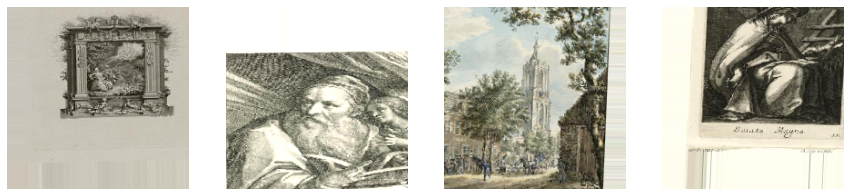

In [42]:
fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(15,15))

for i in range(4):

    # convert to unsigned integers for plotting
    image = next(train_generator)[0][0]
    # changing size from (1, 200, 200, 3) to (200, 200, 3) for plotting the image
    image = np.squeeze(image) * 0.5 + 0.5
    # plot raw pixel data
    ax[i].imshow(image)
    ax[i].axis('off')

In [43]:
def train_model(model, steps_per_epoch=150, epochs=5, validation_steps=70, workers=7, checkpoint_loc=""):
    """
    Trains a given model

    :steps_per_epoch: Amount of batches uploaded per epoch. Cant be higher than +- 200
    :epochs: Amount of times the model trains on the data
    :validation_steps: Amount of batches used for validation. Cant be higher than +- 50
    :workers: Amount of processes used to load the data
    :checkpoint_loc: Place for the model checkpoints to be saved
    :return: The trained model and some training data
    """ 
    # Create a callback that saves the model's weights
#     cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_loc,
#                                                      save_weights_only=True,
#                                                      verbose=1)
    cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_loc,
                                                     monitor='acc',
                                                     save_weights_only=True)
#     cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_loc, 
#                                                      monitor='acc', 
#                                                      save_weights_only=True, 
#                                                      save_best_only=True, 
#                                                      mode='max')

    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)
    begin_time = datetime.datetime.now()
    history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=epochs, validation_data=validation_generator, validation_steps=validation_steps, workers=workers, callbacks=[cp_callback, early_stopping])
    print(datetime.datetime.now() - begin_time)
    return (model, history)

In [44]:
def plot_history(history):
    #Plots the training data.
    plt.plot(history.history['accuracy'], label='accuracy')
    plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    plt.show() 

# EfficientNet model:

In [45]:
def make_model(n_labels):
    base_model = tf.keras.applications.EfficientNetB0(input_shape=IMG_SHAPE,
                          include_top=False,
                          weights='imagenet')
    base_model.trainable = False


    global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
    prediction_layer = tf.keras.layers.Dense(n_labels)

    model = tf.keras.Sequential([
      base_model,
      global_average_layer,
      prediction_layer
    ])

    base_learning_rate = 0.0001
    model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate),
                  loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                  metrics=['accuracy'])
    return model

EfficientNetmodel = make_model(n_labels)
# EfficientNetmodel.summary()

In [27]:
def make_model(n_labels):
    base_model = tf.keras.applications.InceptionV3(input_shape = IMG_SHAPE, 
                                                   weights = 'imagenet', 
                                                   include_top=False)
    for layer in base_model.layers[:249]:
       layer.trainable = False
    for layer in base_model.layers[249:]:
       layer.trainable = True
    x = base_model.output
    
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(1024, activation='relu')(x)
    x = Dense(512, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    pred = Dense(n_labels, activation='softmax')(x)
    model = Model(inputs = base_model.input, outputs = pred)
    
    for layer in model.layers[-8:]:
        layer.trainable=True
        
    model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.001), 
                  loss=tf.keras.losses.BinaryCrossentropy(label_smoothing=0.1), 
                  metrics=['accuracy'])
    
    return model

# EfficientNetmodel = make_model(n_labels)
# EfficientNetmodel.summary()

In [46]:
EfficientNetmodel, history_EfficientNet = train_model(EfficientNetmodel, steps_per_epoch=200, epochs=50, validation_steps=50, checkpoint_loc="../Model_weights/EfficientNetmodel/")


Epoch 1/50
200/200 [==============================] - 180s 860ms/step - loss: 0.2356 - accuracy: 0.0017 - val_loss: 0.0522 - val_accuracy: 0.0014
Epoch 2/50
200/200 [==============================] - 174s 851ms/step - loss: 0.0292 - accuracy: 0.0205 - val_loss: 0.0182 - val_accuracy: 0.0305
Epoch 3/50
200/200 [==============================] - 175s 857ms/step - loss: 0.0187 - accuracy: 0.0301 - val_loss: 0.0176 - val_accuracy: 0.0305
Epoch 4/50
200/200 [==============================] - 176s 859ms/step - loss: 0.0184 - accuracy: 0.0298 - val_loss: 0.0177 - val_accuracy: 0.0305
Epoch 5/50
200/200 [==============================] - 181s 879ms/step - loss: 0.0183 - accuracy: 0.0299 - val_loss: 0.0177 - val_accuracy: 0.0305
Epoch 6/50
200/200 [==============================] - 182s 886ms/step - loss: 0.0183 - accuracy: 0.0299 - val_loss: 0.0177 - val_accuracy: 0.0305
Epoch 7/50
200/200 [==============================] - 183s 890ms/step - loss: 0.0182 - accuracy: 0.0298 - val_loss: 0.0177 -

KeyboardInterrupt: 

In [ ]:
plot_history(history_EfficientNet)

In [36]:
# Save model
EfficientNetmodel.save("models/_InceptionV3model")

# Load model
# EfficientNetmodel = tf.keras.models.load_model('./models/_EfficientNetmodel')


INFO:tensorflow:Assets written to: models/_InceptionV3model\assets


# Predict the test set
We also have to predict the real test set

In [33]:
def predict_test(model):
    preds = model.predict(test_generator)
    preds_cls_idx = preds.argmax(axis=-1)
    idx_to_cls = {v: k for k, v in train_generator.class_indices.items()}
    preds_cls = np.vectorize(idx_to_cls.get)(preds_cls_idx)
    filenames_to_cls = list(zip(test_generator.filenames, preds_cls))
    
    l = []
    n = []
    for p in filenames_to_cls:
        n.append(p[0].split("\\")[-1])
        l.append(p[1])
    return pd.DataFrame(list(zip(n, l)), columns=['img_name','label'])

res = predict_test(EfficientNetmodel)

In [34]:
res

,img_name,label
0,RP-P-1907-4257.jpg,"Luyken, Jan"
1,RP-P-1907-4262.jpg,"Passe, Crispijn van de (I)"
2,RP-P-1907-4264.jpg,"Houbraken, Jacob"
3,RP-P-1907-4266.jpg,"Ostade, Adriaen van"
4,RP-P-1907-4267.jpg,"Passe, Crispijn van de (I)"
...,...,...
13248,RP-P-OB-84.943.jpg,"Janson, Johannes"
13249,RP-P-OB-84.945.jpg,"Berchem, Nicolaes Pietersz"
13250,RP-P-OB-84.946.jpg,"Bagelaar, Ernst Willem Jan"
13251,RP-P-OB-84.951.jpg,"Bernard, Jean"
